In [2]:
pip install geneticalgorithm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15076 sha256=0e56859f2f1b51bdaac316e7ade1d64c0e3cbc321adff3f3a859f2dc4d1d8678
  Stored in directory: /root/.cache/pip/wheels/3f/83/19/b5552bb9630e353f7c5b15be44bf10900afe1abbbfcf536afd
Successfully built func-timeout


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    f1_score, roc_auc_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from geneticalgorithm import geneticalgorithm as ga
import matplotlib.pyplot as plt
import seaborn as sns


In [19]:
class FraudDetectionEngine:
    def __init__(self, data_path):
        # Load and preprocess data
        self.data = pd.read_csv(data_path)
        self.X = self.data.iloc[:, :-1].values  # Features
        self.y = self.data.iloc[:, -1].values  # Target
        self.scaler = MinMaxScaler()
        self.models = {
            "Decision Tree": DecisionTreeClassifier(),
            "Random Forest": RandomForestClassifier(),
            "Logistic Regression": LogisticRegression(),
            "Naive Bayes": GaussianNB(),
            "ANN": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200, random_state=42)
        }
        self.performance = {}
        self.ga_history = None

    def analyze_data(self):
        """Basic dataset analysis."""
        print("\nDataset Information:")
        print(self.data.info())
        print("\nClass Distribution:")
        print(self.data.iloc[:, -1].value_counts())
        sns.countplot(x=self.y)
        plt.title("Class Distribution")
        plt.show()

    def normalize_inputs(self):
        """Normalize features using Min-Max scaling."""
        self.X = self.scaler.fit_transform(self.X)

    def feature_selection(self):
        """Apply Genetic Algorithm (GA) for feature selection."""
        def fitness_function(selected_features):
            selected_features = np.round(selected_features).astype(bool)
            if not any(selected_features):
                return 1e6  # Penalize if no features are selected
            X_selected = self.X[:, selected_features]
            X_train, X_test, y_train, y_test = train_test_split(X_selected, self.y, test_size=0.3, random_state=42)
            model = LogisticRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            return 1 - accuracy_score(y_test, y_pred)  # Minimize error (maximize accuracy)



        algorithm_param = {'max_num_iteration': 100,\
                   'population_size':50,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

        dim = self.X.shape[1]
        varbound = np.array([[0, 1]] * dim)  # Binary selection (0 or 1 for each feature)
        algorithm = ga(function=fitness_function, dimension=dim, variable_type="bool", variable_boundaries=varbound ,
                       algorithm_parameters=algorithm_param)
        algorithm.run()
        self.ga_history = algorithm.report  # Save GA history for plotting
        selected_features = np.round(algorithm.output_dict["variable"]).astype(bool)
        self.X = self.X[:, selected_features]

    def train_and_evaluate(self):
        """Train and evaluate all models."""
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42)
        for name, model in self.models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

            self.performance[name] = {
                "Accuracy": accuracy_score(y_test, y_pred),
                "Recall": recall_score(y_test, y_pred),
                "Precision": precision_score(y_test, y_pred),
                "F1-Score": f1_score(y_test, y_pred),
                "AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
            }

    def plot_ga_convergence(self):
        """Plot GA convergence curve."""
        if self.ga_history is None:
            print("No GA convergence data available.")
            return
        plt.figure(figsize=(8, 5))
        plt.plot(self.ga_history, marker="o")
        plt.title("GA Convergence Curve")
        plt.xlabel("Iterations")
        plt.ylabel("Fitness Value (Error)")
        plt.grid(True)
        plt.show()

    def plot_performance_metrics(self):
        """Plot bar graph for performance metrics and AUC as a line graph."""
        metrics = ["Accuracy", "Recall", "Precision", "F1-Score", "AUC"]
        performance_df = pd.DataFrame(self.performance).T

        # Bar plot for Accuracy, Recall, Precision, F1-Score
        performance_df[metrics[:-1]].plot(kind="bar", figsize=(10, 6))
        plt.title("Performance Metrics Comparison")
        plt.ylabel("Score")
        plt.xlabel("Models")
        plt.legend(loc="lower right")
        plt.grid(axis="y")
        plt.show()

        # Line graph for AUC
        plt.figure(figsize=(8, 5))
        auc_scores = performance_df["AUC"].replace("N/A", 0).astype(float)
        plt.plot(auc_scores, marker="o", linestyle="-", color="b", label="AUC")
        plt.xticks(range(len(auc_scores)), performance_df.index, rotation=45)
        plt.title("AUC Comparison")
        plt.ylabel("AUC Score")
        plt.xlabel("Models")
        plt.legend()
        plt.grid()
        plt.show()

    def display_performance(self):
        """Display performance metrics for each model."""
        performance_df = pd.DataFrame(self.performance).T
        print("\nPerformance Comparison:")
        print(performance_df)


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  f

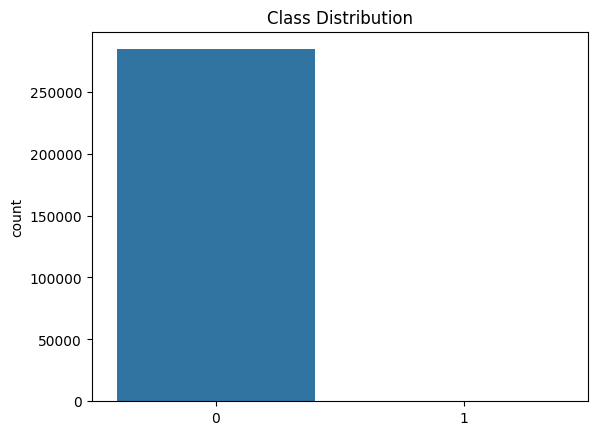

In [20]:
engine = FraudDetectionEngine("creditcard.csv")  # Replace with your dataset path
engine.analyze_data()

 The best solution found:
 [1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0.
 0. 1. 1. 0. 0. 0.]

 Objective function:
 0.0008894818768067081


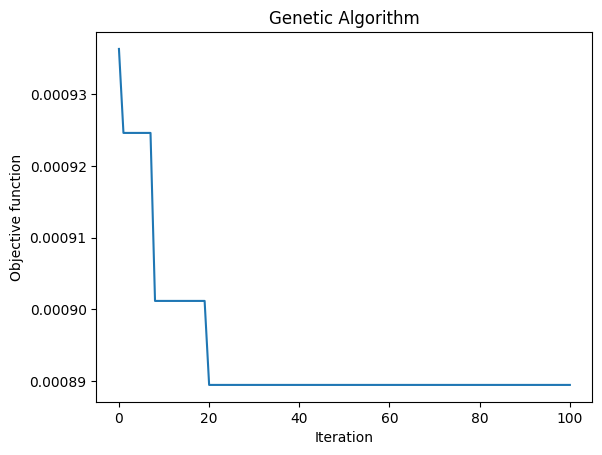

In [21]:
engine.normalize_inputs()
engine.feature_selection()

In [22]:
engine.train_and_evaluate()


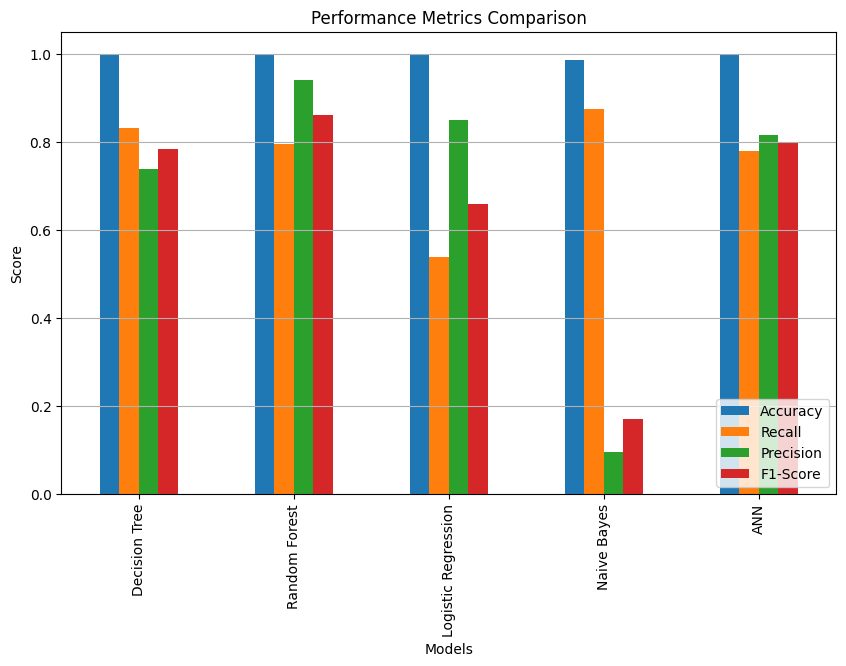

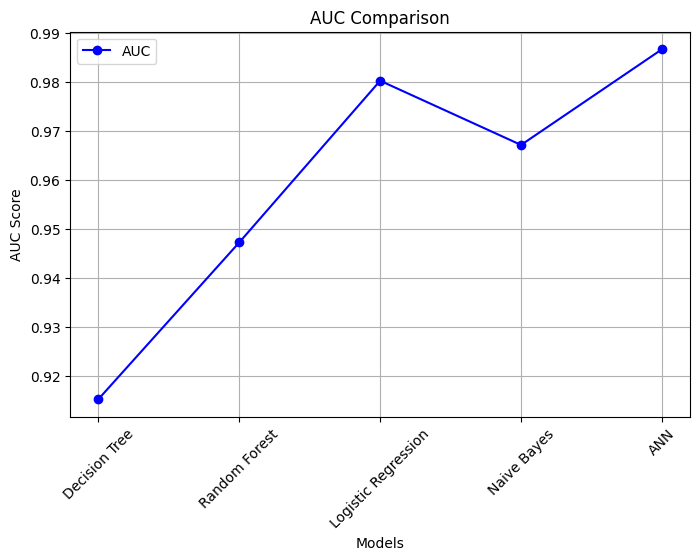

In [27]:
engine.plot_performance_metrics()

In [23]:
engine.display_performance()



Performance Comparison:
                     Accuracy    Recall  Precision  F1-Score       AUC
Decision Tree        0.999263  0.830882   0.738562  0.782007  0.915207
Random Forest        0.999590  0.794118   0.939130  0.860558  0.947259
Logistic Regression  0.999111  0.536765   0.848837  0.657658  0.980309
Naive Bayes          0.986342  0.875000   0.093775  0.169395  0.967184
ANN                  0.999368  0.779412   0.815385  0.796992  0.986738


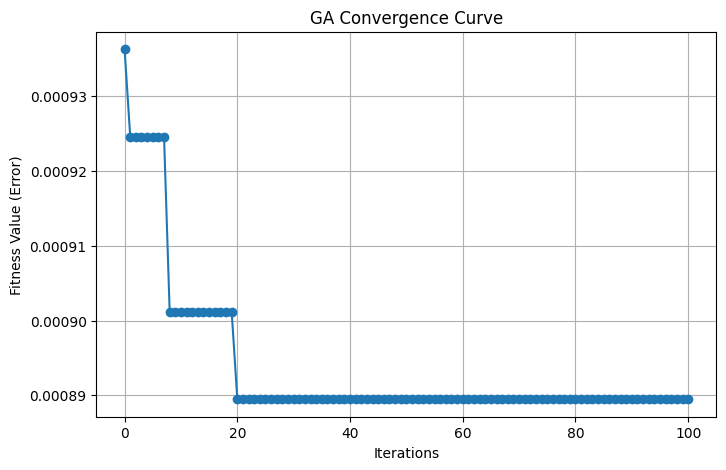

In [24]:
engine.plot_ga_convergence()